In [1]:
import numpy as np
from scipy import optimize
import copy
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
class Flow:
  def __init__(self, name: str,
               mass_flow_rate: float,
               mass_fractions: np.ndarray,
               densities: np.ndarray,
               mole_weights: np.ndarray,
               cp_coeffs: np.ndarray,
               temperature: float) -> None:
    self.name = name
    self.mass_flow_rate = mass_flow_rate
    self.mass_fractions = mass_fractions
    self.n_comps = len(self.mass_fractions)
    self.densities = densities
    self.mole_weights = mole_weights
    self.cp_coeffs = cp_coeffs
    self.temperature = temperature
    self.convert_mass_to_volume_fractions()
    self.convert_mass_to_mole_fractions()
    self.calc_flow_density()
    self.calc_average_molar_mass()
    self.calc_comp_cp()
    self.calc_avr_cp()
    self.volume_flow_rate = self.mass_flow_rate / self.density

  def convert_mass_to_volume_fractions(self) -> np.ndarray:
    x = self.mass_fractions / self.densities
    s = x.sum()
    self.volume_fractions = x / s

  def convert_mass_to_mole_fractions(self) -> np.ndarray:
    x = self.mass_fractions / self.mole_weights
    s = x.sum()
    self.mole_fractions = x / s

  def calc_flow_density(self) -> float:
    self.density = (self.mass_fractions / (1000 * self.densities)).sum() ** (-1)

  def calc_average_molar_mass(self) -> float:
    self.mole_mass = (self.mass_fractions / self.mole_weights).sum() ** (-1)

  def calc_comp_cp(self) -> np.ndarray:
    self.comp_cp = np.zeros(self.n_comps)
    for i in range(self.n_comps):
      for j in range(len(self.cp_coeffs[0])):
        self.comp_cp[i] += j * self.cp_coeffs[i, j] * self.temperature**j

  def calc_avr_cp(self) -> float:
    self.avr_cp = (self.mass_fractions * self.comp_cp).sum()

  def set_t(self, temperature: float) -> None:
    self.temperature = temperature
    self.calc_comp_cp()
    self.calc_avr_cp()

  def describe(self) -> None:
    print(f'Имя потока: {self.name}')
    print(f'Температура = {self.temperature:1.2f} °С')
    print(f'Теплоемкость = {self.avr_cp:1.3f} кДж/кг')
    print(f'Массовый расход = {self.mass_flow_rate:1.2f} кг/ч')
    print(f'Объемный расход = {self.volume_flow_rate:1.3f} м3/ч')
    print(f'Плотность = {self.density:1.3f} кг/м3')
    print('Массовые доли:')
    for i in range(self.n_comps):
      print(f'{self.mass_fractions[i]:1.3f} кг/кг')
    print(20 * '-')

class Mixer:
  def mix(self, name, *flows: Flow) -> Flow:
    self.flows = flows

    self.mass_flow_rate = np.sum([flow.mass_flow_rate for flow in self.flows])

    self.mass_fractions = np.sum(
    [flow.mass_fractions * flow.mass_flow_rate for flow in self.flows],
    axis=0,
    ) / self.mass_flow_rate

    t_mean = self.__calc_t_mix()

    self.mixture = Flow(name=name,
                        mass_flow_rate=self.mass_flow_rate,
                        mass_fractions=self.mass_fractions,
                        densities=self.flows[0].densities,
                        mole_weights=self.flows[0].mole_weights,
                        cp_coeffs=self.flows[0].cp_coeffs,
                        temperature=t_mean)

    return self.mixture

  def __calc_t_mix(self) -> float:
    def cp_func(T: float) -> float:
      n_comps = self.flows[0].n_comps
      comp_cp = np.zeros(n_comps)
      for i in range(n_comps):
        for j in range(len(self.flows[0].cp_coeffs[0])):
          comp_cp[i] += j * self.flows[0].cp_coeffs[i, j] * T**j
      cp_mix = (self.mass_fractions * comp_cp).sum()
      err = np.sum(
      [flow.mass_flow_rate * flow.avr_cp * flow.temperature for flow in self.flows]
      ) / (self.mass_flow_rate * cp_mix) - T
      return err
    t_mix = optimize.root_scalar(f=cp_func, bracket=[1, 1000],
            x0=270, x1=370, method='secant').root
    return t_mix

class HeatExchanger():
  def __init__(self, d_in: float = 0.1,
               d_out: float = 0.25,
               length: float = 3.0,
               k: float = 4900) -> None:
    self.d_in = d_in
    self.d_out = d_out
    self.length = length
    self.k = k
    self.l_eval = np.linspace(0, self.length, 1000)

  def calculate(self, hot: Flow, hot_name: str,
                cold: Flow, cold_name: str) -> tuple[Flow]:
    hot_out = copy.copy(hot)
    cold_out = copy.copy(cold)
    self.hot_name = hot_name
    self.cold_name = cold_name
    hot_out.name = self.hot_name
    cold_out.name = self.cold_name

    def right_parts(l: float,
                    y: tuple[float]) -> tuple[float]:
      dt_h = - self.k * np.pi * self.d_in / (hot_out.volume_flow_rate *
            hot_out.density * hot_out.avr_cp) * (y[0] - y[1])
      dt_c = self.k * np.pi * self.d_in / (cold_out.volume_flow_rate *
            cold_out.density * cold_out.avr_cp) * (y[0] - y[1])
      hot_out.set_t(y[0])
      cold_out.set_t(y[1])

      return dt_h, dt_c

    solution = solve_ivp(right_parts, (0, self.length),
            (hot_out.temperature, cold_out.temperature),
                     t_eval=self.l_eval)

    self.hot_profile = solution.y[0]
    self.cold_profile = solution.y[1]

    return (hot_out, cold_out)

class Splitter():
  def calculate(self, flow: Flow, names: list[str],
                ratio: list[float] = [1.0]) -> list[Flow]:
    n_out_flows = len(ratio)
    ratio = [ratio[i] / sum(ratio) for i in range(n_out_flows)]
    out_flows = []
    for number in range(n_out_flows):
      new_flow = copy.copy(flow)
      new_flow.name = names[number]
      new_flow.mass_flow_rate = flow.mass_flow_rate * ratio[number]
      out_flows.append(new_flow)
    return out_flows

In [3]:
cp_coeffs = np.array([[0.071254, 0.002979, -0.0000007, 0, 0],
                     [13.83761, 0.0003, 0.000000346, -0.000000000097, 0.00000000000000773],
                     [-0.09689, 0.003473, -0.0000013, 0.000000000256, -0.000000000000014],
                     [0.9985, -0.00018, 0.000000557, -0.00000000032, 0.0000000000000637]])
densities = np.array([0.821537454674234, 8.57E-5,
                         0.634118153548788, 0.0138331933625558])
mole_weights = np.array([128.1332, 2.02, 131.82935, 34.01])

In [4]:
flow1 = Flow(name = 'flow1',
             mass_flow_rate=1000,
             mass_fractions=np.array([0.80, 0.0, 0.15, 0.0]),
             densities=densities,
             mole_weights=mole_weights,
             cp_coeffs=cp_coeffs,
             temperature=363)

flow2 = Flow(name = 'flow2',
             mass_flow_rate=1500,
             mass_fractions=np.array([0.80, 0.02, 0.15, 0.03]),
             densities=densities,
             mole_weights=mole_weights,
             cp_coeffs=cp_coeffs,
             temperature=353)

flow3 = Flow(name = 'flow3',
             mass_flow_rate=1200,
             mass_fractions=np.array([0.9, 0.01, 0.08, 0.01]),
             densities=densities,
             mole_weights=mole_weights,
             cp_coeffs=cp_coeffs,
             temperature=373)

flow8 = Flow(name = 'flow8',
             mass_flow_rate=2500,
             mass_fractions=np.array([0.75, 0.03, 0.21, 0.01]),
             densities=densities,
             mole_weights=mole_weights,
             cp_coeffs=cp_coeffs,
             temperature=293)

mixer1 = Mixer()
flow4 = mixer1.mix('flow4', flow1, flow2, flow3)

he1 = HeatExchanger()
flow5, flow9 = he1.calculate(flow4, 'flow5', flow8, 'flow9')

spl1 = Splitter()
flow6, flow7 = spl1.calculate(flow5, ['flow6', 'flow7'], [2, 3])

flows = [flow1, flow2, flow3, flow4, flow5, flow6, flow7, flow8, flow9]

for flow in flows:
  flow.describe()

Имя потока: flow1
Температура = 363.00 °С
Теплоемкость = 0.861 кДж/кг
Массовый расход = 1000.00 кг/ч
Объемный расход = 1.210 м3/ч
Плотность = 826.219 кг/м3
Массовые доли:
0.800 кг/кг
0.000 кг/кг
0.150 кг/кг
0.000 кг/кг
--------------------
Имя потока: flow2
Температура = 353.00 °С
Теплоемкость = 0.847 кДж/кг
Массовый расход = 1500.00 кг/ч
Объемный расход = 355.127 м3/ч
Плотность = 4.224 кг/м3
Массовые доли:
0.800 кг/кг
0.020 кг/кг
0.150 кг/кг
0.030 кг/кг
--------------------
Имя потока: flow3
Температура = 373.00 °С
Теплоемкость = 0.905 кДж/кг
Массовый расход = 1200.00 кг/ч
Объемный расход = 142.357 м3/ч
Плотность = 8.430 кг/м3
Массовые доли:
0.900 кг/кг
0.010 кг/кг
0.080 кг/кг
0.010 кг/кг
--------------------
Имя потока: flow4
Температура = 362.34 °С
Теплоемкость = 0.870 кДж/кг
Массовый расход = 3700.00 кг/ч
Объемный расход = 498.694 м3/ч
Плотность = 7.419 кг/м3
Массовые доли:
0.832 кг/кг
0.011 кг/кг
0.127 кг/кг
0.015 кг/кг
--------------------
Имя потока: flow5
Температура = 336.45 °

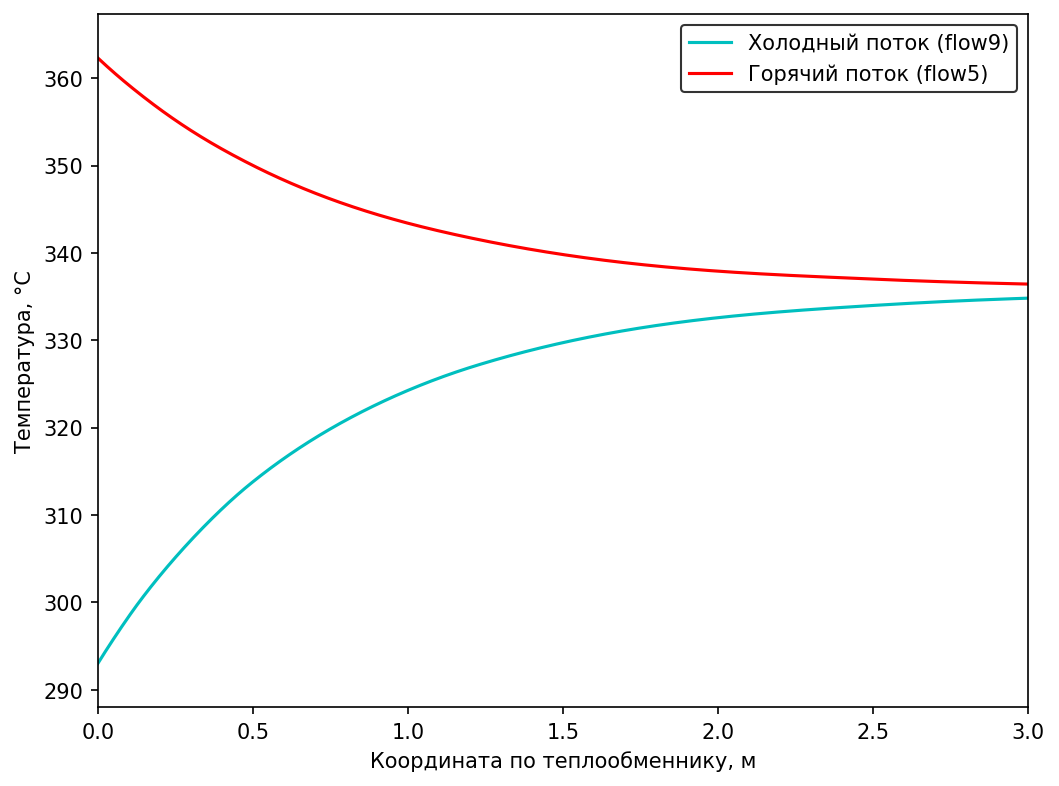

In [5]:
fig = plt.figure(figsize=(8,6), dpi=150)
ax = fig.add_subplot(xlim=[0, he1.length], ylim=[he1.cold_profile[0]-5, he1.hot_profile[0]+5])
ax.plot(he1.l_eval, he1.cold_profile, c='c', label=f'Холодный поток ({he1.cold_name})')
ax.plot(he1.l_eval, he1.hot_profile, c='r', label=f'Горячий поток ({he1.hot_name})')
ax.legend(frameon=True, edgecolor='black')
ax.set_xlabel('Координата по теплообменнику, м')
ax.set_ylabel('Температура, °С');